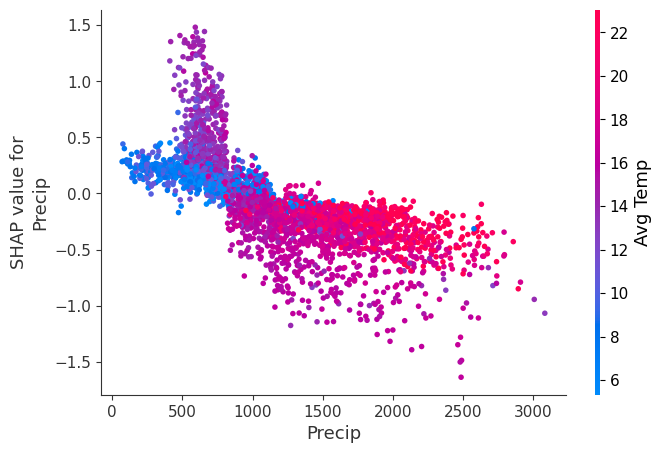

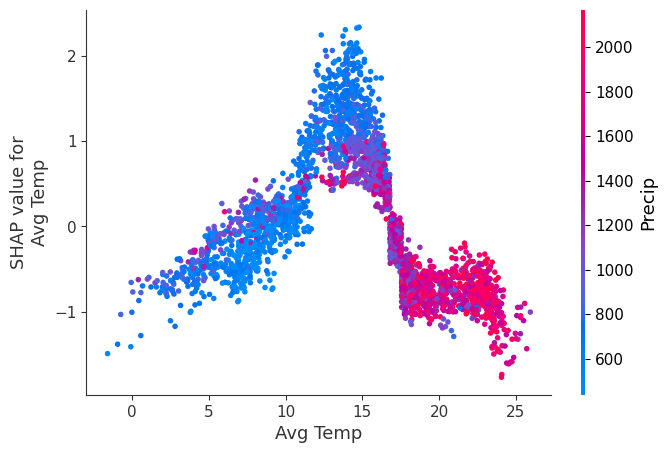

In [7]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 读取 Excel 文件
yaqem_df = pd.read_excel("YAQEM.xlsx")
xne_df = pd.read_excel("XNE.xlsx")
xtn_df = pd.read_excel("XTN.xlsx")
xec_df = pd.read_excel("XEC.xlsx")

# 选择空气质量相关特征进行 PCA 降维
air_quality_features = ["CO", "NO2", "O3", "PM2_5", "PM10", "SO2"]
yaqem_filtered = yaqem_df[air_quality_features].dropna()

scaler = StandardScaler()
yaqem_scaled = scaler.fit_transform(yaqem_filtered)

pca = PCA(n_components=1)
yaqem_pca = pca.fit_transform(yaqem_scaled)

yaqem_df["AirQualityIndex"] = yaqem_pca

# 确保 `year` 列唯一，删除重复列
xne_df = xne_df.loc[:, ~xne_df.columns.duplicated()]
xtn_df = xtn_df.loc[:, ~xtn_df.columns.duplicated()]
xec_df = xec_df.loc[:, ~xec_df.columns.duplicated()]
yaqem_df = yaqem_df.loc[:, ~yaqem_df.columns.duplicated()]

# 直接指定 20 个数据特征列名，并修正 RFV -> RoadFV, RPT -> RoadPT
feature_columns = [
    "Precip", "NDVI", "Avg Temp",  # 自然环境 (XNE)
    "RoadFV", "RoadPT", "TFT", "TPT", "NBP", "NOT", "TAP", "RailFV", "RailPT",  # 交通 (XTN)
    "UREC", "IE", "TRCGNG", "TEC", "WSV", "TLS", "Tot Res LPG", "Tot Gas Supply"  # 能源 (XEC)
]

# 合并数据
x_data = xne_df.merge(xtn_df, on=["city", "year"], how="outer")
x_data = x_data.merge(xec_df, on=["city", "year"], how="outer")

# 确保 `year` 只出现一次
x_data = x_data.loc[:, ~x_data.columns.duplicated()]

# 仅保留指定的 20 个特征
x_data = x_data[["city", "year", "quyu"] + feature_columns]

# 合并 X 和 Y 数据（使用 left join 确保数据不丢失）
final_data = yaqem_df[["city", "year", "AirQualityIndex", "quyu"]].merge(x_data, on=["city", "year", "quyu"], how="left")

# 使用 fillna(0) 填充缺失值，确保 X 数据完整
final_data_cleaned = final_data.fillna(0)

# 处理非数值列：将 RailFV, TLS 和 Tot Res LPG 转换为数值
final_data_cleaned["RailFV"] = pd.to_numeric(final_data_cleaned["RailFV"], errors='coerce')
final_data_cleaned["TLS"] = pd.to_numeric(final_data_cleaned["TLS"], errors='coerce')
final_data_cleaned["Tot Res LPG"] = pd.to_numeric(final_data_cleaned["Tot Res LPG"], errors='coerce')

# 选择全区域数据
final_data_cleaned_all = final_data_cleaned

# 选择特征和目标变量
X_all = final_data_cleaned_all[feature_columns]
Y_all = final_data_cleaned_all["AirQualityIndex"]

# 训练 XGBoost 模型
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X_all, Y_all)

# 计算 SHAP 值
explainer = shap.Explainer(model)
shap_values_all = explainer(X_all)

# 绘制 SHAP 值依赖图（全区域）
shap_values_data = shap_values_all.values  # 获取 SHAP 值

# 绘制特征 "Precip" 的 SHAP 依赖图
shap.dependence_plot("Precip", shap_values_data, X_all, display_features=X_all)
plt.show()

# 如果你想分析其他特征的影响，比如 "Avg Temp"
shap.dependence_plot("Avg Temp", shap_values_data, X_all, display_features=X_all)
plt.show()
